In [1]:
from aicsimageio import AICSImage, imread
from aicsimageio.writers import PngWriter
from pathlib import Path
import napari
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import torch
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from tqdm import tqdm

In [2]:
def get_paths(dir_path, ext):
    return [str(path) for path in Path(dir_path).rglob('*.{}'.format(ext))]

In [3]:
ext_tiff = 'czi'
folder_tiff = '../../../datasets/microscopy_luke'

In [4]:
files = get_paths(folder_tiff, ext_tiff)

In [5]:
len(files)

1540

In [6]:
test = AICSImage(files[0])
test = test.get_image_data("CZYX", S=0, T=0).squeeze(1)
test.shape

/home/victor/anaconda3/envs/sr/lib/python3.7/site-packages/aicsimageio/transforms.py:178: UserWarning: Data has dimension B with depth 1, assuming B=0 is the desired value, if not the case specify B=x where x is an integer, list, tuple, range, or slice.
  f"Data has dimension {dim} with depth {data.shape[dim_index]}, "
/home/victor/anaconda3/envs/sr/lib/python3.7/site-packages/aicsimageio/transforms.py:178: UserWarning: Data has dimension V with depth 1, assuming V=0 is the desired value, if not the case specify V=x where x is an integer, list, tuple, range, or slice.
  f"Data has dimension {dim} with depth {data.shape[dim_index]}, "


(5, 1024, 1024)

In [7]:
def AICS_to_grayscale(img_path, chanel, stack=False):
    img = AICSImage(img_path)
    img = img.get_image_data("CZYX", S=0, T=0)
    img = img.squeeze(1)

    if img.shape[0] != 5:
        print('INVALID SHAPE', img_path, img.shape[0])
    
    if img.shape[0] >= chanel:
        img = np.asarray(img)[chanel]
    else:
        print('INVALID SHAPE', img_path, img.shape[0])
        return None
    
    if stack:
        img = np.stack([img, img, img], 2)

    return img

In [8]:
# for f in tqdm(files):
#     _ = AICS_to_grayscale(f, 2)

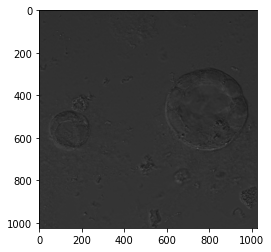

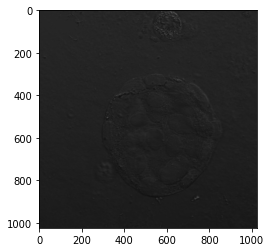

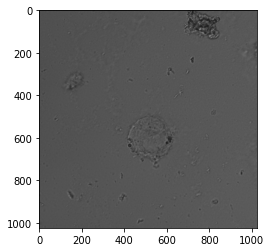

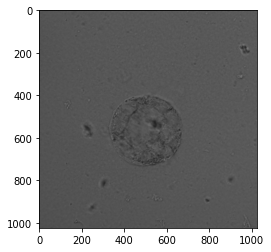

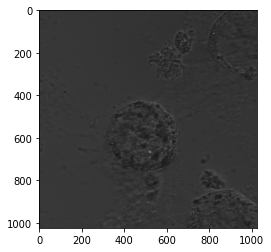

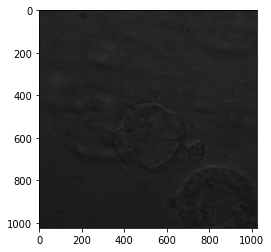

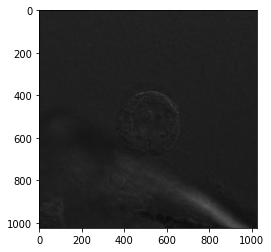

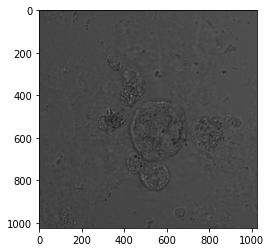

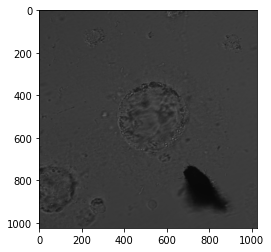

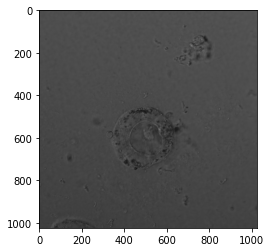

In [9]:
for i in range(10):
    img = AICS_to_grayscale(files[i], 3, stack=True)
    plt.figure()
    plt.imshow(img)

In [11]:
def downsample_save(files, chanel, scale_factor, ds_dir):
    
    lr_dir = os.path.join(ds_dir, 'lr_{}x'.format(scale_factor))
    hr_dir = os.path.join(ds_dir, 'hr'.format(scale_factor))
    
    os.makedirs(lr_dir, exist_ok=True)
    os.makedirs(hr_dir, exist_ok=True)
    
    trans = transforms.ToTensor()
    
    for i, f in enumerate(tqdm(files, 'saving')):
        hr = AICS_to_grayscale(files[i], chanel, stack=True)
        
        hr_name = os.path.join(hr_dir, 'sample_{}.png'.format(i))        
        lr_name = os.path.join(lr_dir, 'sample_{}.png'.format(i))
        
        if hr is not None and not (os.path.exists(hr_name) and os.path.exists(lr_name)):
            
            hr = trans(hr).unsqueeze(0)

            lr = F.interpolate(hr, scale_factor=scale_factor, mode='bicubic', align_corners=True)

            hr_pil = to_pil_image(hr.squeeze(0))
            lr_pil = to_pil_image(lr.squeeze(0))

            if not os.path.exists(hr_name):
                hr_pil.save(hr_name)

            lr_pil.save(lr_name)

In [13]:
downsample_save(files, chanel=2, scale_factor=1/4, ds_dir='data/czi')

saving:   0%|          | 0/1540 [00:00<?, ?it/s]

torch.Size([1, 3, 1024, 1024])


saving:   0%|          | 1/1540 [00:00<13:45,  1.87it/s]

torch.Size([1, 3, 1024, 1024])


saving:   0%|          | 2/1540 [00:01<13:20,  1.92it/s]

torch.Size([1, 3, 1024, 1024])


saving:   0%|          | 3/1540 [00:01<12:55,  1.98it/s]

torch.Size([1, 3, 1024, 1024])


saving:   0%|          | 4/1540 [00:02<13:09,  1.94it/s]

torch.Size([1, 3, 1024, 1024])


saving:   0%|          | 5/1540 [00:02<12:46,  2.00it/s]

torch.Size([1, 3, 1024, 1024])


saving:   0%|          | 6/1540 [00:02<12:28,  2.05it/s]

torch.Size([1, 3, 1024, 1024])


saving:   0%|          | 7/1540 [00:03<12:21,  2.07it/s]

torch.Size([1, 3, 1024, 1024])


saving:   1%|          | 8/1540 [00:03<11:59,  2.13it/s]

torch.Size([1, 3, 1024, 1024])


saving:   1%|          | 9/1540 [00:04<11:49,  2.16it/s]

torch.Size([1, 3, 1024, 1024])


saving:   1%|          | 10/1540 [00:04<12:12,  2.09it/s]

torch.Size([1, 3, 1024, 1024])


saving:   1%|          | 11/1540 [00:05<11:57,  2.13it/s]

torch.Size([1, 3, 1024, 1024])


saving:   1%|          | 13/1540 [00:06<11:37,  2.19it/s]

torch.Size([1, 3, 1024, 1024])
torch.Size([1, 3, 1024, 1024])


saving:   1%|          | 14/1540 [00:06<11:28,  2.21it/s]

torch.Size([1, 3, 1024, 1024])


saving:   1%|          | 16/1540 [00:07<11:12,  2.27it/s]

torch.Size([1, 3, 1024, 1024])
torch.Size([1, 3, 1024, 1024])


saving:   1%|          | 17/1540 [00:07<11:46,  2.15it/s]

torch.Size([1, 3, 1024, 1024])


saving:   1%|          | 18/1540 [00:08<12:25,  2.04it/s]

torch.Size([1, 3, 1024, 1024])


saving:   1%|          | 19/1540 [00:09<12:15,  2.07it/s]

torch.Size([1, 3, 1024, 1024])


saving:   1%|▏         | 21/1540 [00:09<12:00,  2.11it/s]

torch.Size([1, 3, 1024, 1024])
torch.Size([1, 3, 1024, 1024])


saving:   1%|▏         | 22/1540 [00:10<11:44,  2.15it/s]

torch.Size([1, 3, 1024, 1024])


saving:   1%|▏         | 23/1540 [00:10<11:34,  2.19it/s]

torch.Size([1, 3, 1024, 1024])


saving:   2%|▏         | 25/1540 [00:11<11:16,  2.24it/s]

torch.Size([1, 3, 1024, 1024])


saving:   2%|▏         | 26/1540 [00:12<11:11,  2.25it/s]

torch.Size([1, 3, 1024, 1024])
torch.Size([1, 3, 1024, 1024])


saving:   2%|▏         | 27/1540 [00:12<11:15,  2.24it/s]

torch.Size([1, 3, 1024, 1024])


saving:   2%|▏         | 29/1540 [00:13<11:09,  2.26it/s]

torch.Size([1, 3, 1024, 1024])
torch.Size([1, 3, 1024, 1024])


saving:   2%|▏         | 30/1540 [00:14<11:59,  2.10it/s]

torch.Size([1, 3, 1024, 1024])


saving:   2%|▏         | 31/1540 [00:14<11:53,  2.12it/s]

torch.Size([1, 3, 1024, 1024])


saving:   2%|▏         | 32/1540 [00:14<11:36,  2.17it/s]

torch.Size([1, 3, 1024, 1024])


saving:   2%|▏         | 33/1540 [00:15<12:28,  2.01it/s]

torch.Size([1, 3, 1024, 1024])


saving:   2%|▏         | 34/1540 [00:16<11:57,  2.10it/s]


KeyboardInterrupt: 

In [12]:
downsample_save(files, chanel=2, scale_factor=1/8, ds_dir='data/czi')

saving:   0%|          | 0/1540 [00:00<?, ?it/s]/home/victor/anaconda3/envs/sr/lib/python3.7/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
saving: 100%|██████████| 1540/1540 [10:41<00:00,  2.40it/s]


In [ ]:
downsample_save(files, chanel=2, scale_factor=1/16, ds_dir='data/czi')

saving:  15%|█▌        | 231/1540 [00:49<04:31,  4.81it/s]